Lets start by importing the necessary libraries.

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

Downloading the dataset from Kaggle

Ref: [Guide](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kostastzoumpas","key":"6dad699b680bbe6a766847b0b7cce86f"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d landlord/handwriting-recognition
!mkdir /kaggle
!mkdir /kaggle/input
!mkdir /kaggle/input/handwriting-recognition
!unzip handwriting-recognition.zip -d /kaggle/input/handwriting-recognition/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
handwriting-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


A couple of utility functions to plot/process images:

In [ ]:
def crop_picture(PATH, verbose=False):
    # load image
    img = Image.open(PATH)
    pixels=img.convert('1').load()
    # get dimensions
    w, h = img.size
        
    # Create a smaller frame in the center of the image
    # ws = width start, we = width end, hs ... , he ...
    ws = int(w * 0.4) # width starts from 40%
    we = int(w * 0.7) # goes until 70 %
    hs = int(0.5 * h) # height starts from 50%
    he = hs + 4 # int(0.52 * h) # goes until 50% + 4 pixels
    # save dimensions of the frame
    cur_frame = [ws, hs, we, he]
    # current (smaller) image
    cur_img = img.crop(tuple(cur_frame)).convert('1') # '1' for 1-bit pixels, black and white, stored with one pixel per byte
    # pixels inside this frame only
    cur_pixels = cur_img.load()
    # compute image's entropy
    entropy = cur_img.entropy()

    # define a threshold for each line to stop searching for new black pixels
    thr_val_vert = 2
    thr_val_hor = 16
    # starting thresholds
    threshold = [thr_val_vert, int(0.2*h), thr_val_hor, thr_val_hor]
    
    # save previous width start (ws) value for continue searching until first black pixel found
    black_found_w = False
    black_found_h = False
    height_resized = False
    
    # Start expanding the frame to every edge, until only white pixels are found
    while (ws >= 0 or hs >= 0 and we < w and he < h):
        
        # define the four lines of the frame
        line_up = [cur_pixels[l, 0] for l in range(we-ws)]
        line_down = [cur_pixels[l, he-hs-1] for l in range(we-ws)]
        line_left = [cur_pixels[0, l] for l in range(he-hs)]
        line_right = [cur_pixels[we-ws-1, l] for l in range(he-hs)]
        # save them in a list
        lines = [line_left, line_up, line_right, line_down]
        
        
        
        # if a line contains black pixel(s) or threshold has not been exceeded, expand it
        # if a dimension has reached its end, stop changing it by setting the threshold to 0
        if threshold[0] > 0 or 0 in line_up:
            hs = max(0, hs-1)
            if 0 in line_up and hs > 0:
                threshold[0] = thr_val_vert
            else:
                threshold[0] -= 1
        
        if threshold[1] > 0 or 0 in line_down:
            he = min(h, he+1)
            if 0 in line_down and he < h:
                threshold[1] = thr_val_vert
                #black_found_h = True
                # if black found on the bottom line, move down also the upper line
                hs += 1
            else:
                threshold[1] -= 1
        
        if threshold[2] > 0:
            ws -= 1
            if 0 in line_left:
                threshold[2] = thr_val_hor
                black_found_w = True
            elif black_found_w:
                threshold[2] -= 1
        if threshold[3] > 0:
            we += 1
            if 0 in line_right:
                threshold[3] = 4
            else:
                threshold[3] -= 1
        
        threshold[0] = max(threshold[0] * int(not hs == 1), 0)
        threshold[1] = max(threshold[1] * int(not he == h - 1), 0)
        threshold[2] = max(threshold[2] * int(not ws == 1), 0)
        threshold[3] = max(threshold[3] * int(not we == w - 1), 0)


        # if all lines are totally white, no expand needed. Otherwise, it will expand
        if [ws, hs, we, he] != cur_frame:            
            # change dimensions of the frame - expand it
            cur_frame = [ws, hs, we, he]
            # current - smaller - image
            cur_img = img.crop(tuple(cur_frame)).convert('1')
            # pixels inside this frame only
            cur_pixels = cur_img.load()
            # get image entropy
            entropy = cur_img.entropy()
        elif threshold == [0] * 4:
            break
        
        # Printing
        if verbose:
            print("Image dimensions: ", h, w, "Current frame: ", cur_frame)
            print("Thresholds: ", threshold)
            #print(lines)
            
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(1, 2, 1)
            plt.imshow(np.asarray(img), cmap='gray')
            ax = plt.subplot(1, 2, 2)
            plt.imshow(np.asarray(cur_img), cmap= 'gray')
    
    if 0.37 > entropy > 0.11:
        returned_img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
        return returned_img[hs:he, ws:we], entropy
    else:
        return None, entropy

In [ ]:
# a function for adding white pixels to images
# they are all returned to the same size (64, 256)

def preprocess(img):
    shapes = img.shape
    h = shapes[0]
    w = shapes[1]
        
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    try:
        final_img = np.ones([64, 256])*255 # blank white image
        final_img[:h, :w] = img
    except:
        final_img = np.ones([64, 256, shapes[2]])*255 # blank white image
        final_img[:h, :w, :] = img
    return final_img

In [ ]:
def plot_images(img_dir, dataset, num_imgs, after_prediction=False, cropped=False, specific_set=None):

    # set size of figure
    cols = min(num_imgs, 5)
    rows = round(num_imgs/cols)        
    plt.figure(figsize=(30, rows * 4))
    
    if specific_set is None:
        imgs = random.sample(range(0, globals()[dataset+'_size']), num_imgs)
    else:
        imgs = specific_set[:num_imgs]
    
    for i in imgs:
        # pick a spot in the figure
        ax = plt.subplot(rows, cols, imgs.index(i)+1)
        plt.axis('off')
        
        # image to plot
        if cropped:
            image, _ = crop_picture(img_dir + globals()[dataset].loc[i, 'FILENAME'])
        else:
            image = cv2.imread(img_dir + globals()[dataset].loc[i, 'FILENAME'], cv2.IMREAD_GRAYSCALE)

        if image is not None:
            plt.imshow(image, cmap = 'gray')
            # if the label is predicted
            if after_prediction:
                # transfor the image for putting it into the prediction model
                image = preprocess(image)
                image = image/255.

                # make prediction
                pred = model.predict(image.reshape(1, 64, 256, 1))
                decoded = keras.backend.get_value(keras.backend.ctc_decode(pred,
                                                                           input_length=np.ones(pred.shape[0])*pred.shape[1],
                                                                           greedy=True)[0][0])
                plt.title(tokenizer.sequences_to_texts([decoded[0].tolist()])[0].upper(), fontsize=14)
            else:
                plt.title(globals()[dataset].loc[i, 'IDENTITY'], fontsize=14)
        else:
            plt.imshow(cv2.imread(img_dir + globals()[dataset].loc[i, 'FILENAME'], cv2.IMREAD_GRAYSCALE))
            plt.title('EXCLUDED' + ' - ' + 'Entropy: ' + str(_), fontsize=14)

    plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Load and view data

Decide the size (fow now we use small sizes because of small amount of RAM)

In [ ]:
train_size = 35000
valid_size = 10000
test_size = 4000

In [ ]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')
train_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'
valid_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'
test_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'

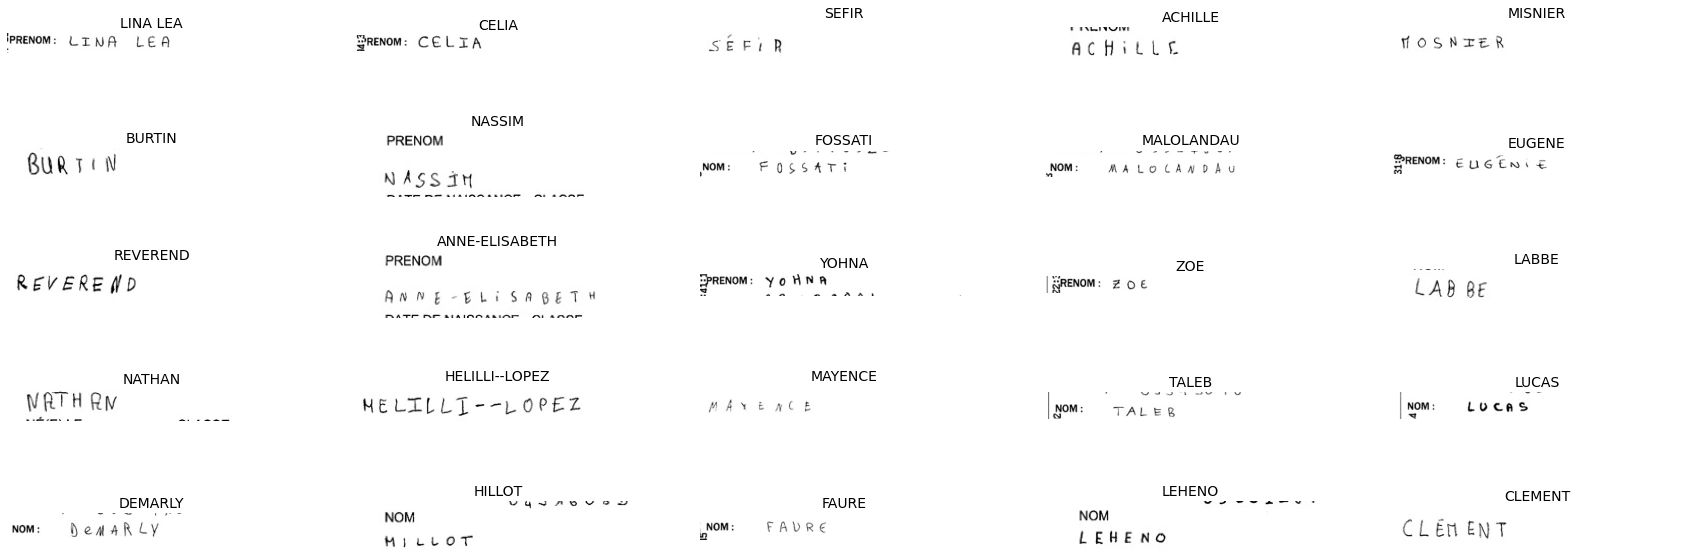

In [ ]:
plot_images(train_dir, 'train', 25)

## Cleaning Data

Let's check for NaNs in our label.

In [ ]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set : ", test['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78
Number of NaNs in test set :  70


Let's remove them and check again.

In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set : ", test['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0
Number of NaNs in test set :  0


Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

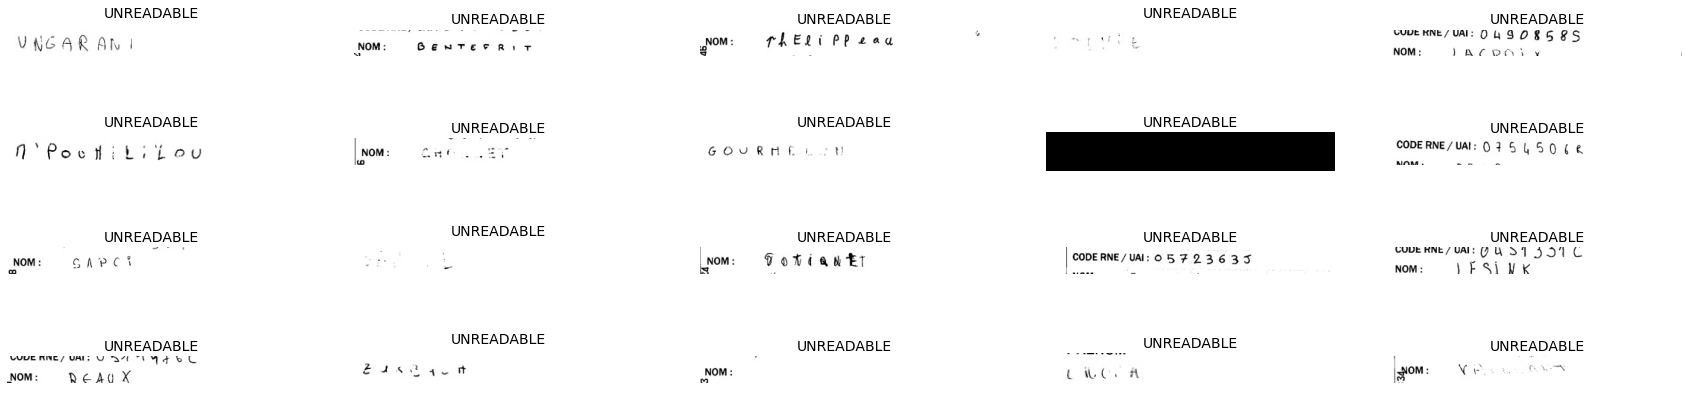

In [ ]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)
unreadable_size = unreadable.shape[0]
plot_images(train_dir, 'unreadable', 20)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

Reset the index and we are done with cleaning. 

In [ ]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and the unwanted characters are removed. Then, they are reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels.
* The image is then normalized to range [0, 1]

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image, entropy = crop_picture(img_dir)
    if image is not None:
        image = preprocess(image)
        image = image/255.
        train_x.append(image)
    else:
        train.drop([i], inplace=True)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image, entropy = crop_picture(img_dir)
    if image is not None:
        image = preprocess(image)
        image = image/255.
        valid_x.append(image)
    else:
        valid.drop([i], inplace=True)

In [ ]:
test_x = []

for i in range(test_size):
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image, entropy = crop_picture(img_dir)
    if image is not None:
        image = preprocess(image)
        image = image/255.
        test_x.append(image)
    else:
        test.drop([i], inplace=True)

Resetting again

In [ ]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

Reshaping image datasets and update sizes

In [ ]:
train_x = np.array(train_x).reshape(-1, 64, 256, 1)
valid_x = np.array(valid_x).reshape(-1, 64, 256, 1)
test_x = np.array(test_x).reshape(-1, 64, 256, 1)

In [ ]:
print(train_x.shape, valid_x.shape, test_x.shape)
train_size = train_x.shape[0]
valid_size = valid_x.shape[0]
test_size = test_x.shape[0]

(29129, 64, 256, 1) (8346, 64, 256, 1) (3391, 64, 256, 1)


Let's test some images from the validation set, but the cropped version:

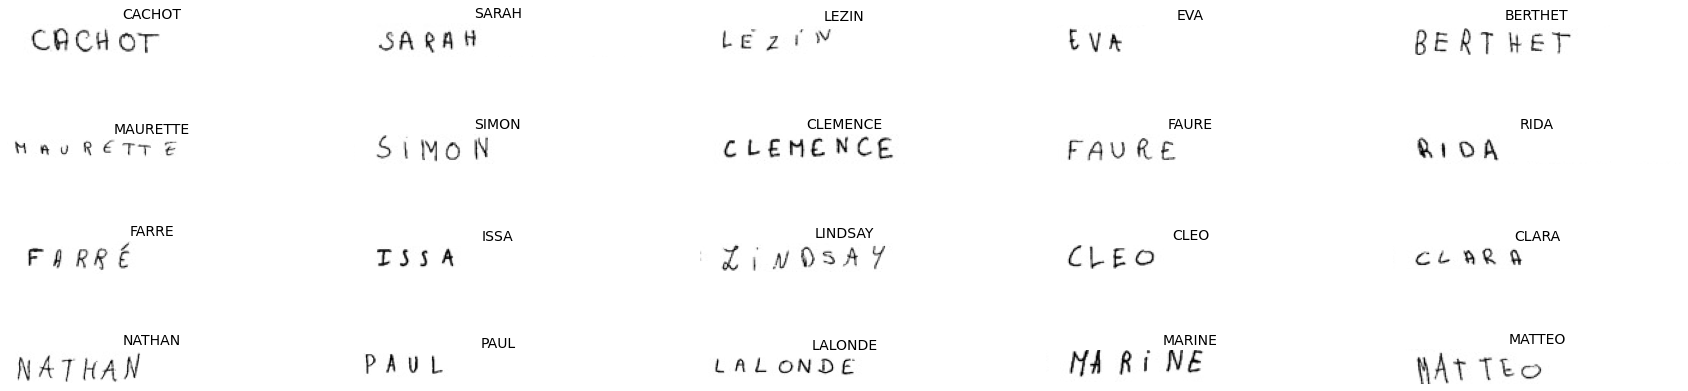

In [ ]:
plot_images(valid_dir, 'valid', 20, cropped=True)

## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space). 

In [ ]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
num_of_characters = len(alphabet) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of input labels

# tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(alphabet)

# test
print(tokenizer.texts_to_sequences(["NAME SURNAME"])) # expected [[14, 1, 13, 5, 29, 19, 21, 18, 14, 1, 13, 5]]
print(tokenizer.sequences_to_texts([[14, 1, 13, 5, 29, 19, 21, 18, 14, 1, 13, 5]]))

[[14, 1, 13, 5, 29, 19, 21, 18, 14, 1, 13, 5]]
['n a m e   s u r n a m e']


Find max string length

In [ ]:
len_train = [len(train['IDENTITY'][i]) for i in range(train_size)]
len_valid = [len(valid['IDENTITY'][i]) for i in range(valid_size)]
len_test = [len(test['IDENTITY'][i]) for i in range(len(test['IDENTITY']))]

max_str_len = max(max(len_train), max(len_valid), max(len_test), num_of_characters) # max length predicted labels , setting minimum 25
print("Maximum string length: " + str(max_str_len))

Maximum string length: 30


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len. 
* **train_label_len** contains the length of each true label (without padding) 
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss.

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * num_of_timestamps
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= tokenizer.texts_to_sequences([train.loc[i, 'IDENTITY']])[0]

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * num_of_timestamps
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= tokenizer.texts_to_sequences([valid.loc[i, 'IDENTITY']])[0]

In [ ]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * num_of_timestamps
test_output = np.zeros([test_size])

for i in range(test_size):
    test_label_len[i] = len(test.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test.loc[i, 'IDENTITY'])]= tokenizer.texts_to_sequences([test.loc[i, 'IDENTITY']])[0]

Test if the above is set correctly

In [ ]:
print('True label : ',train.loc[233, 'IDENTITY'] , '\ntrain_y : ',train_y[233],'\ntrain_label_len : ',train_label_len[233], 
      '\ntrain_input_len : ', train_input_len[233])

True label :  DYLAN 
train_y :  [ 4. 25. 12.  1. 14. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [5.] 
train_input_len :  [64.]


In [ ]:
print('True label : ',valid.loc[100, 'IDENTITY'] , '\ntrain_y : ',valid_y[100],'\ntrain_label_len : ',valid_label_len[100], 
      '\ntrain_input_len : ', valid_input_len[100])

True label :  FRENOT 
train_y :  [ 6. 18.  5. 14. 15. 20. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [6.] 
train_input_len :  [64.]


## Building the model


Let's create a Layer for connecting model output to ctc loss function

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        
        loss_fn = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss_fn)

        # At test time, just return the computed value of loss function
        return y_pred #self.loss_fn

In [ ]:
# clear session before starting over
keras.backend.clear_session()

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME", kernel_initializer="he_normal")

model = keras.models.Sequential([
    keras.layers.Input(shape=(64, 256, 1,)),
    DefaultConv2D(filters=16),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    
    DefaultConv2D(filters=32),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    
    DefaultConv2D(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    
    DefaultConv2D(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    
    # CNN TO RNN
    keras.layers.Reshape(target_shape=((64, 128)), name='reshape'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1'),
    
    # RNN
    keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True), name = 'lstm1'),
    keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True), name = 'lstm2'),
    
    # OUTPUT
    keras.layers.Dense(max_str_len + 1,activation='softmax', name='dense2')
])

In [ ]:
labels = keras.layers.Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = keras.layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = keras.layers.Input(name='label_length', shape=[1], dtype='int64')
y_pred = model.output

# ctc loss function
loss_fun = CTCLayer(name="loss_function")(labels, y_pred, input_length, label_length)

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 256, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 256, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 64, 256, 16)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 128, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 128, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 128, 32)       0

In [ ]:
# Create final model (with ctc loss)

model_final = keras.models.Model(inputs=(model.input, labels, input_length, label_length),
                                outputs=loss_fun)

In [ ]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 256, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 256, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 256, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# fit model and save to history for some printing

model_final.compile(optimizer=keras.optimizers.Adam())

Predict

In [ ]:
epochs = 40
early_stopping_patience = 10

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = early_stopping_patience,
    restore_best_weights = True
)

# Train the model
history = model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,
    validation_data=((valid_x, valid_y, valid_input_len, valid_label_len), valid_output),
    epochs=epochs,
    callbacks=[early_stopping],
    batch_size=32
)


Epoch 1/40
911/911 [==============================] - 63s 56ms/step - loss: 18.2440 - val_loss: 5.0743
Epoch 2/40
911/911 [==============================] - 48s 53ms/step - loss: 5.2635 - val_loss: 3.6170
Epoch 3/40
911/911 [==============================] - 49s 53ms/step - loss: 3.9660 - val_loss: 3.2046
Epoch 4/40
911/911 [==============================] - 49s 53ms/step - loss: 3.4190 - val_loss: 3.1034
Epoch 5/40
911/911 [==============================] - 49s 54ms/step - loss: 3.0933 - val_loss: 3.1020
Epoch 6/40
911/911 [==============================] - 49s 53ms/step - loss: 2.8077 - val_loss: 4.3814
Epoch 7/40
911/911 [==============================] - 49s 54ms/step - loss: 2.5969 - val_loss: 2.7010
Epoch 8/40
911/911 [==============================] - 49s 54ms/step - loss: 2.4070 - val_loss: 2.7648
Epoch 9/40
911/911 [==============================] - 49s 54ms/step - loss: 2.1976 - val_loss: 2.6979
Epoch 10/40
911/911 [==============================] - 49s 53ms/step - loss: 2.07

Learning curves

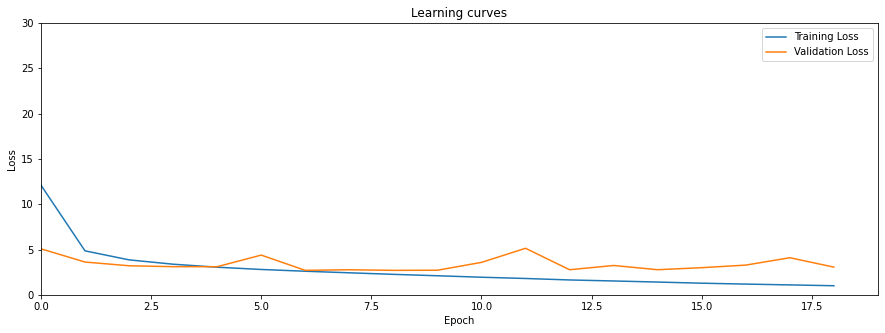

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,5))

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,30])
plt.xlabel('Epoch')
plt.xlim([0,len(loss)])

plt.title('Learning curves')
plt.show()

## Check model performance on validation set

In [ ]:
# make predictions
preds = model.predict(valid_x)

# transform predictions using ctc function   |   j,j,j, , , o, o, o, o, , , h, , , n, n, n, n   ->   john
decoded = keras.backend.get_value(keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                                           greedy=True)[0][0])

# transform predictions (numbers) to characters
prediction = []
given_labels = []
for i in range(valid_size):
    to_text = [[el] for el in decoded[i] if el != -1]
    prediction.append(tokenizer.sequences_to_texts(to_text))
    to_text = [[el] for el in valid_y[i] if el != -1]
    given_labels.append(tokenizer.sequences_to_texts(to_text))

In [ ]:
# compare and count predicted labels with real labels

correct_char = 0
total_char = 0
correct = 0

wrong_predictions = []
predicted_labels = []

for i in range(valid_size):
    pr = ''.join(prediction[i]).upper()
    tr = ''.join(given_labels[i]).upper()
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1
    else:
        # save its position in the set
        wrong_predictions.append(i)
        predicted_labels.append(pr)
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 88.45%
Correct words predicted      : 75.43%


## Check model performance on test set

In [ ]:
# make predictions
preds = model.predict(test_x)

# transform predictions using ctc function   |   j,j,j, , , o, o, o, o, , , h, , , n, n, n, n   ->   john
decoded = keras.backend.get_value(keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                                           greedy=True)[0][0])

# transform predictions (numbers) to characters
prediction = []
given_labels = []
for i in range(test_size):
    to_text = [[el] for el in decoded[i] if el != -1]
    prediction.append(tokenizer.sequences_to_texts(to_text))
    to_text = [[el] for el in test_y[i] if el != -1]
    given_labels.append(tokenizer.sequences_to_texts(to_text))

In [ ]:
# compare and count predicted labels with real labels

correct_char = 0
total_char = 0
correct = 0

for i in range(test_size):
    pr = ''.join(prediction[i]).upper()
    tr = ''.join(given_labels[i]).upper()
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/test_size))

Correct characters predicted : 87.62%
Correct words predicted      : 74.93%


## Finally, print some predictions

- On validation set

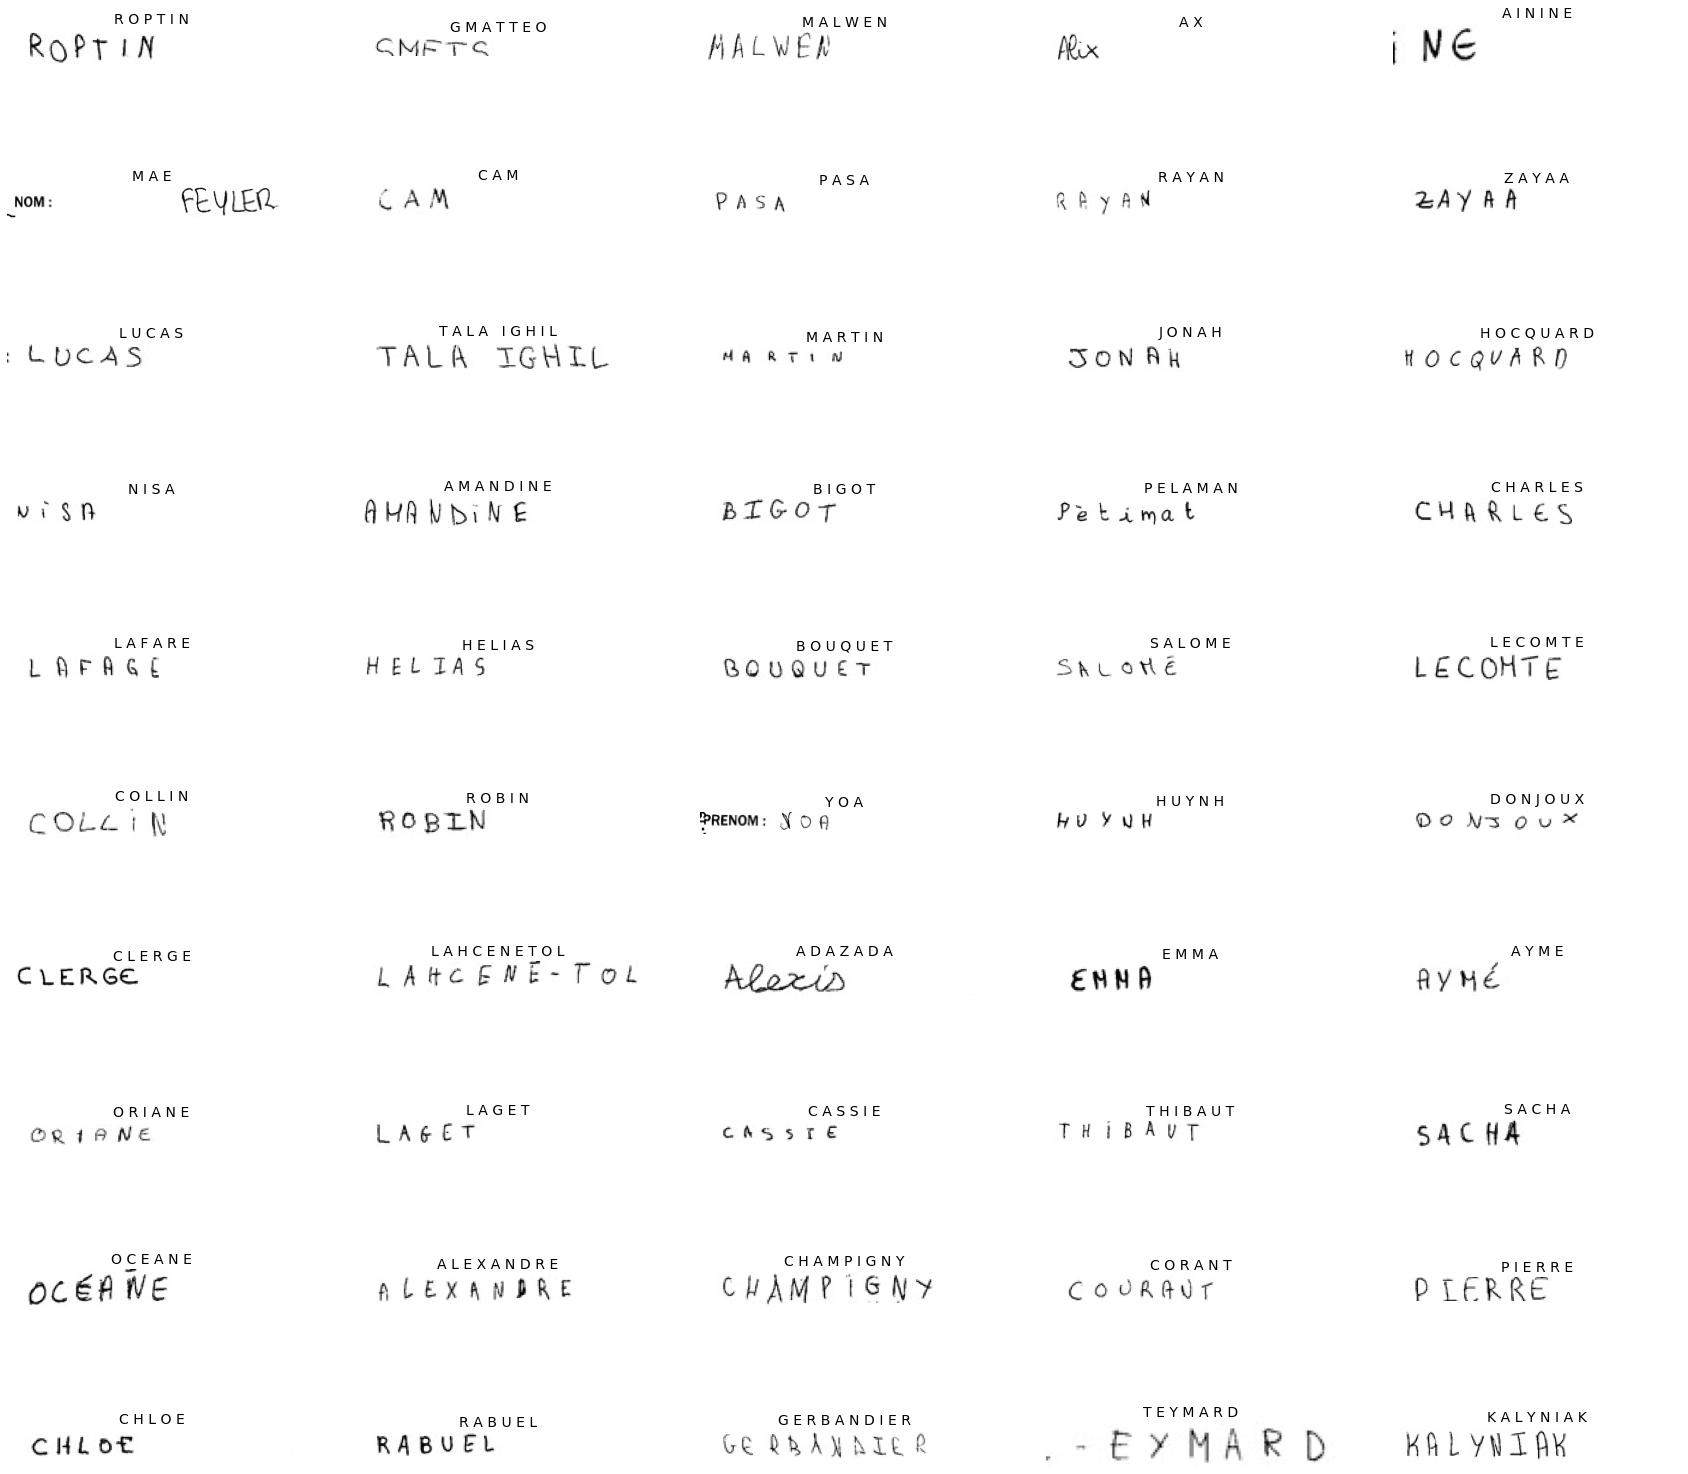

In [ ]:
plot_images(valid_dir, 'valid', 50, after_prediction=True, cropped=True)

- On test set

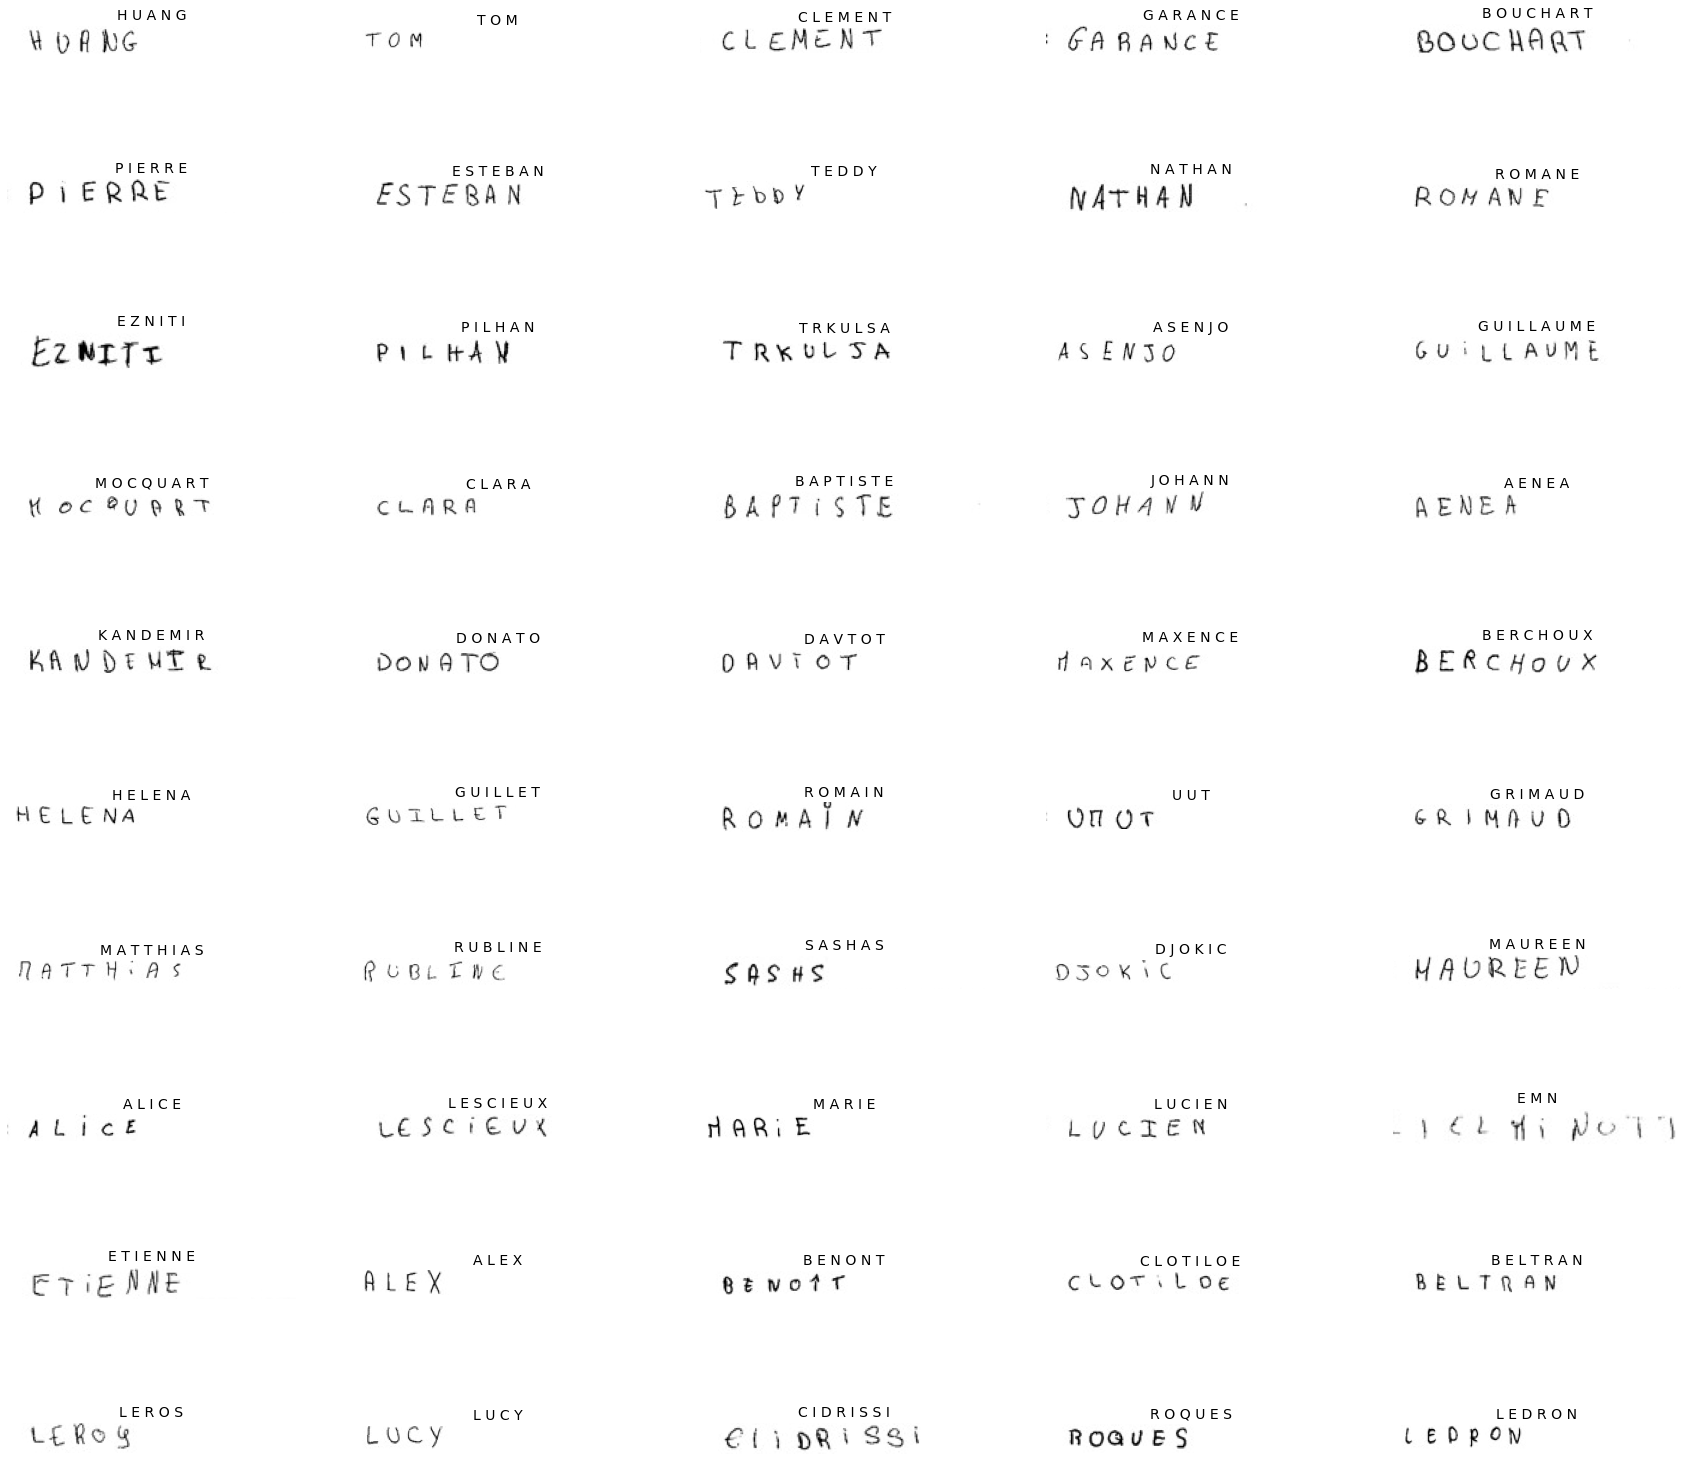

In [ ]:
plot_images(test_dir, 'test', 50, after_prediction=True, cropped=True)

## Print those that were predicted wrongly from the validation set

['LAUMONIER', 'BILGLER', 'ELEN', 'DEVANLAY', 'HOCQVARD', 'BRIVAT', 'MONSH', 'BELMERROURI', 'LOUSSE', 'DWAMGR', 'AXEA', 'CONAS', 'NEU', 'DAUID', 'JOA', 'QUEAM', 'DEPAUY', 'SORRISE', 'ELOUAFA', 'WALIO', 'ERZ', 'ROSARIO', 'SAHIER', 'CAMBE', 'FETOUANI', 'SALENE', 'GEMAN', 'LOU-ANNIE', 'ASMARD', 'GIDIKI', 'CAM', 'TIMOTHE', 'IVIERER', 'ROUSTANA', 'FONSEVA', 'MANIOR', 'PARROT', 'SELLAY-AHMN', 'PRETE', 'SOEZICHARIE', 'NOGAA', 'PONTVER-DE', 'CAWIR', 'AISSATOU', 'TTOUAN', 'MATSTHIES', 'PERRET', 'TOM-ELIOTT', 'GUILHEM', 'SAMBOU', 'RICARDEST', 'SCHWEIDER', 'M', 'OSEMA', 'AYAN', 'LIUU', 'LEMU', 'HUGHE', 'HEBEL', 'RENOAT']


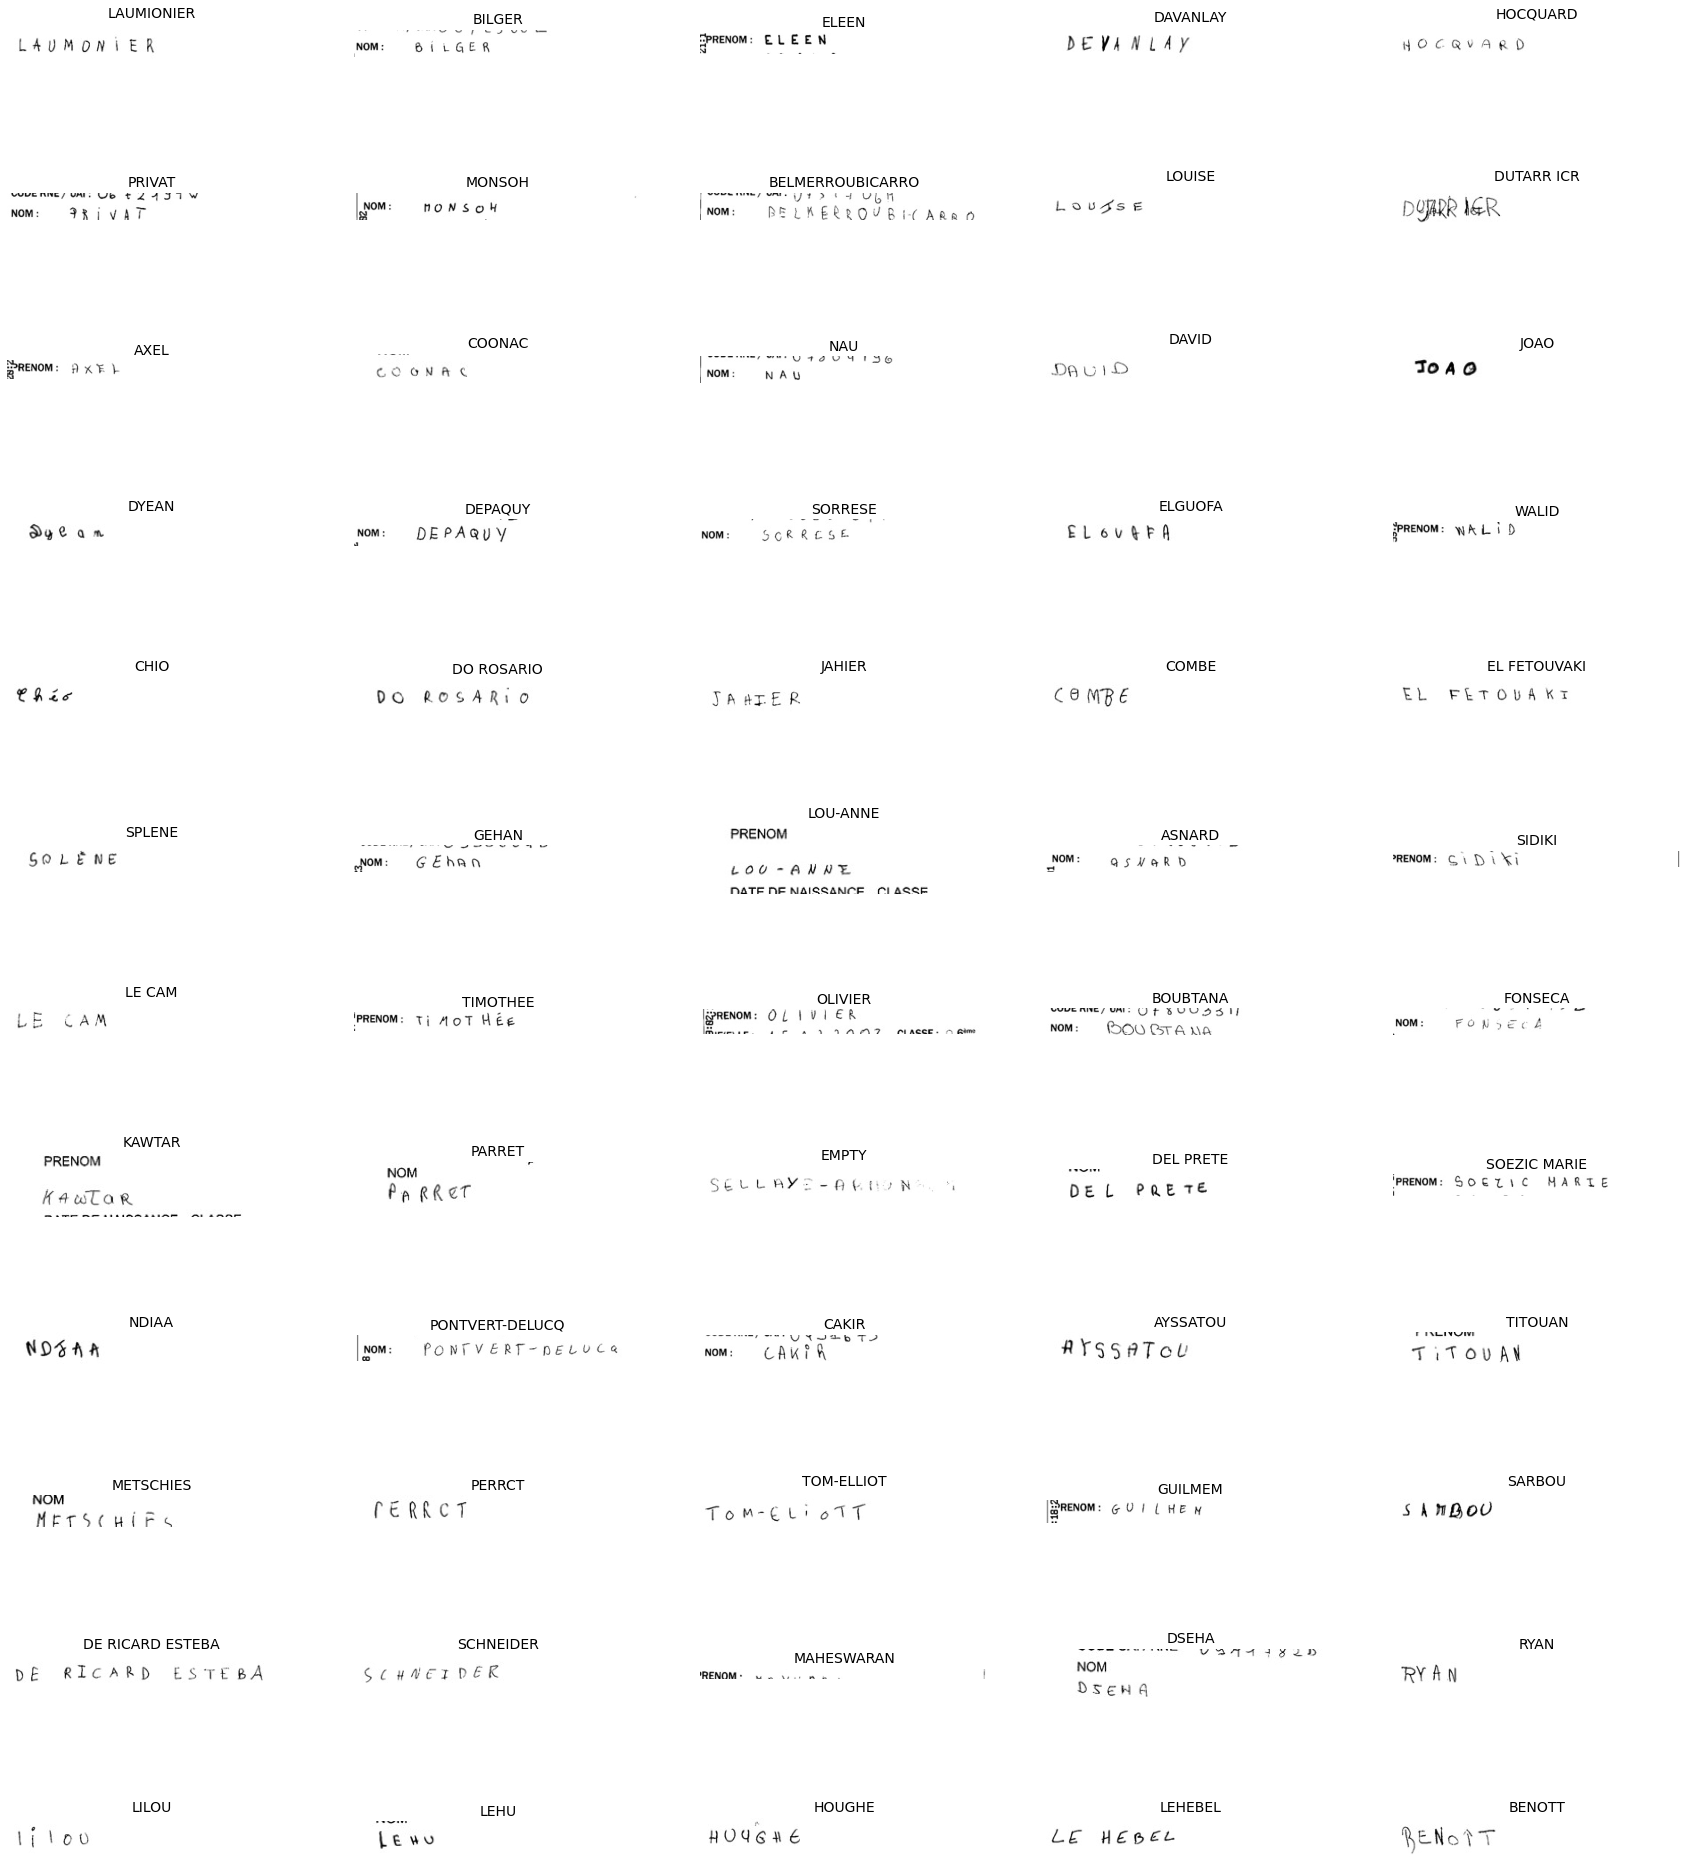

In [ ]:
plot_images(valid_dir, 'valid', 60, cropped=False, specific_set=wrong_predictions)
print(predicted_labels[:60])

# print them uncropped to be sure about their content